##**Library Imports**

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

from bs4 import BeautifulSoup
from html import unescape

from collections import Counter, namedtuple

from IPython.display import Markdown, display
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle

from tqdm import tqdm
import time
from os import path
import sys

if 'contractions' not in sys.modules:
  !{sys.executable} -m pip install contractions

import contractions

if 'transformers' not in sys.modules:
  !{sys.executable} -m pip install transformers

from transformers import BertTokenizerFast, BertForSequenceClassification, BertModel, BatchEncoding, get_linear_schedule_with_warmup

import torch
import torch.nn as nn


## **Data Preprocessing and Statistics**

In [ ]:
def removeHTML(text):
  soup = BeautifulSoup(text)
  soup = BeautifulSoup(unescape(soup.get_text()), 'lxml')
  return soup.get_text()

def fixContractions(tweet):
  expanded_words = []    
  for word in tweet.split():
    expanded_words.append(contractions.fix(word).lower())
  return expanded_words

# All the neccessary cleaning for the data
def preprocessing(df, column):
  # Lowercasing all characters in order to treat all words in a same way
  df[column] = df[column].str.lower()
  # Removal of tweet mentions (names appeared in mentions are not so important)
  df['tweet'] = df['tweet'].str.replace(r'@\S+', '', regex = True)
  # Retweet removal
  df[column] = df[column].str.replace(r'\s+rt|^rt', '', regex = True)
  # URL and HTML tag cleaning (some links dont make any sense and are not so important)
  df[column] = df[column].str.replace(r'http\S+|www.\S+', '', regex = True)
  df[column] = df[column].apply(removeHTML)
  # Contraction fixing
  df[column] = df[column].apply(lambda tweet: ' '.join(fixContractions(tweet)))
  # Whitespace removal
  df[column] = df[column].str.replace(r'\s+', ' ', regex = True)
  # Empty tweet removal
  df = df[df[column] != '']

**Dataset loading** and **preprocessing** using the above functions. Εxtensive cleaning is not necessary because Bert itself uses a smart tokenizer (**WordPiece**) to break the words into tokens. But some words may add some **noise** to the meaning of the tweets (e.g urls, html tags, mentions, retweets) so it is good practice to remove them. Also in order to normalize more the text, the **contractions** are fixed into their full forms.

In [ ]:
#LOAD TEST SET AS ./vaccine_validation_set.csv OR GIVE THE RIGHT PATH

# Reading the two csv files with pandas
training_set = pd.read_csv('./vaccine_train_set.csv', encoding = 'utf-8')
validation_set = pd.read_csv('./vaccine_validation_set.csv', encoding = 'utf-8')
print('\nBefore cleaning:')
display(training_set.head(10))
display(validation_set.head(10))


preprocessing(training_set, 'tweet')
preprocessing(validation_set, 'tweet')

print('\nAfter cleaning:')
display(training_set.head(10))
display(validation_set.head(10))


Before cleaning:


,Unnamed: 0,tweet,label
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,1,I don't know about you but My family and I wil...,1
2,2,@MSignorile Immunizations should be mandatory....,2
3,3,President Obama spoke in favor of vaccination ...,0
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
5,5,Why did I get my whooping cough vaccine the sa...,2
6,6,Prosecutor Ken Ervin: I want to know how reckl...,0
7,7,"""@UberFacts: On average, people who complain l...",0
8,8,The legacy of @JennyMcCarthy will be she took ...,2
9,9,"“@UberFacts: On average, people who complain l...",0


,Unnamed: 0,tweet,label
0,0,@user They had a massive surge in with covid d...,1
1,1,Required vaccines for school: Parents and guar...,0
2,2,“@KCStar: Two more Johnson County children hav...,0
3,3,NV can do better. Which states are the best (a...,2
4,4,Nothing like killing ourselves w/ our own fear...,2
5,5,I'm not subscribing to the panic du jour. Now ...,0
6,6,@801PUNX Fav songs to check out APTBS = Explod...,0
7,7,What happend to the other Covid-19 vaccine tes...,0
8,8,The zenith of #BS --&gt;&gt; CDC Says Ebola Va...,0
9,9,@dlockyer This is the second occurrence I read...,1



After cleaning:


,Unnamed: 0,tweet,label
0,0,sip n shop come thru right now #marjais #popul...,0
1,1,i do not know about you but my family and i wi...,1
2,2,immunizations should be mandatory. period. in ...,2
3,3,president obama spoke in favor of vaccination ...,0
4,4,""" arizona monitoring hundreds for measles link...",0
5,5,why did i get my whooping cough vaccine the sa...,2
6,6,prosecutor ken ervin: i want to know how reckl...,0
7,7,""" on average, people who complain live longer ...",0
8,8,the legacy of will be she took her clothes off...,2
9,9,"“ on average, people who complain live longer ...",0


,Unnamed: 0,tweet,label
0,0,they had a massive surge in with covid deaths ...,1
1,1,required vaccines for school: parents and guar...,0
2,2,“ two more johnson county children have measles,0
3,3,nv can do better. which states are the best (a...,2
4,4,nothing like killing ourselves w/ our own fear...,2
5,5,i am not subscribing to the panic du jour. now...,0
6,6,fav songs to check out aptbs = exploding head ...,0
7,7,what happend to the other covid-19 vaccine tes...,0
8,8,the zenith of #bs -->> cdc says ebola vaccine ...,0
9,9,this is the second occurrence i read of vaccin...,1


Visualization of the results extracted from the **statistical analysis** for the tweets

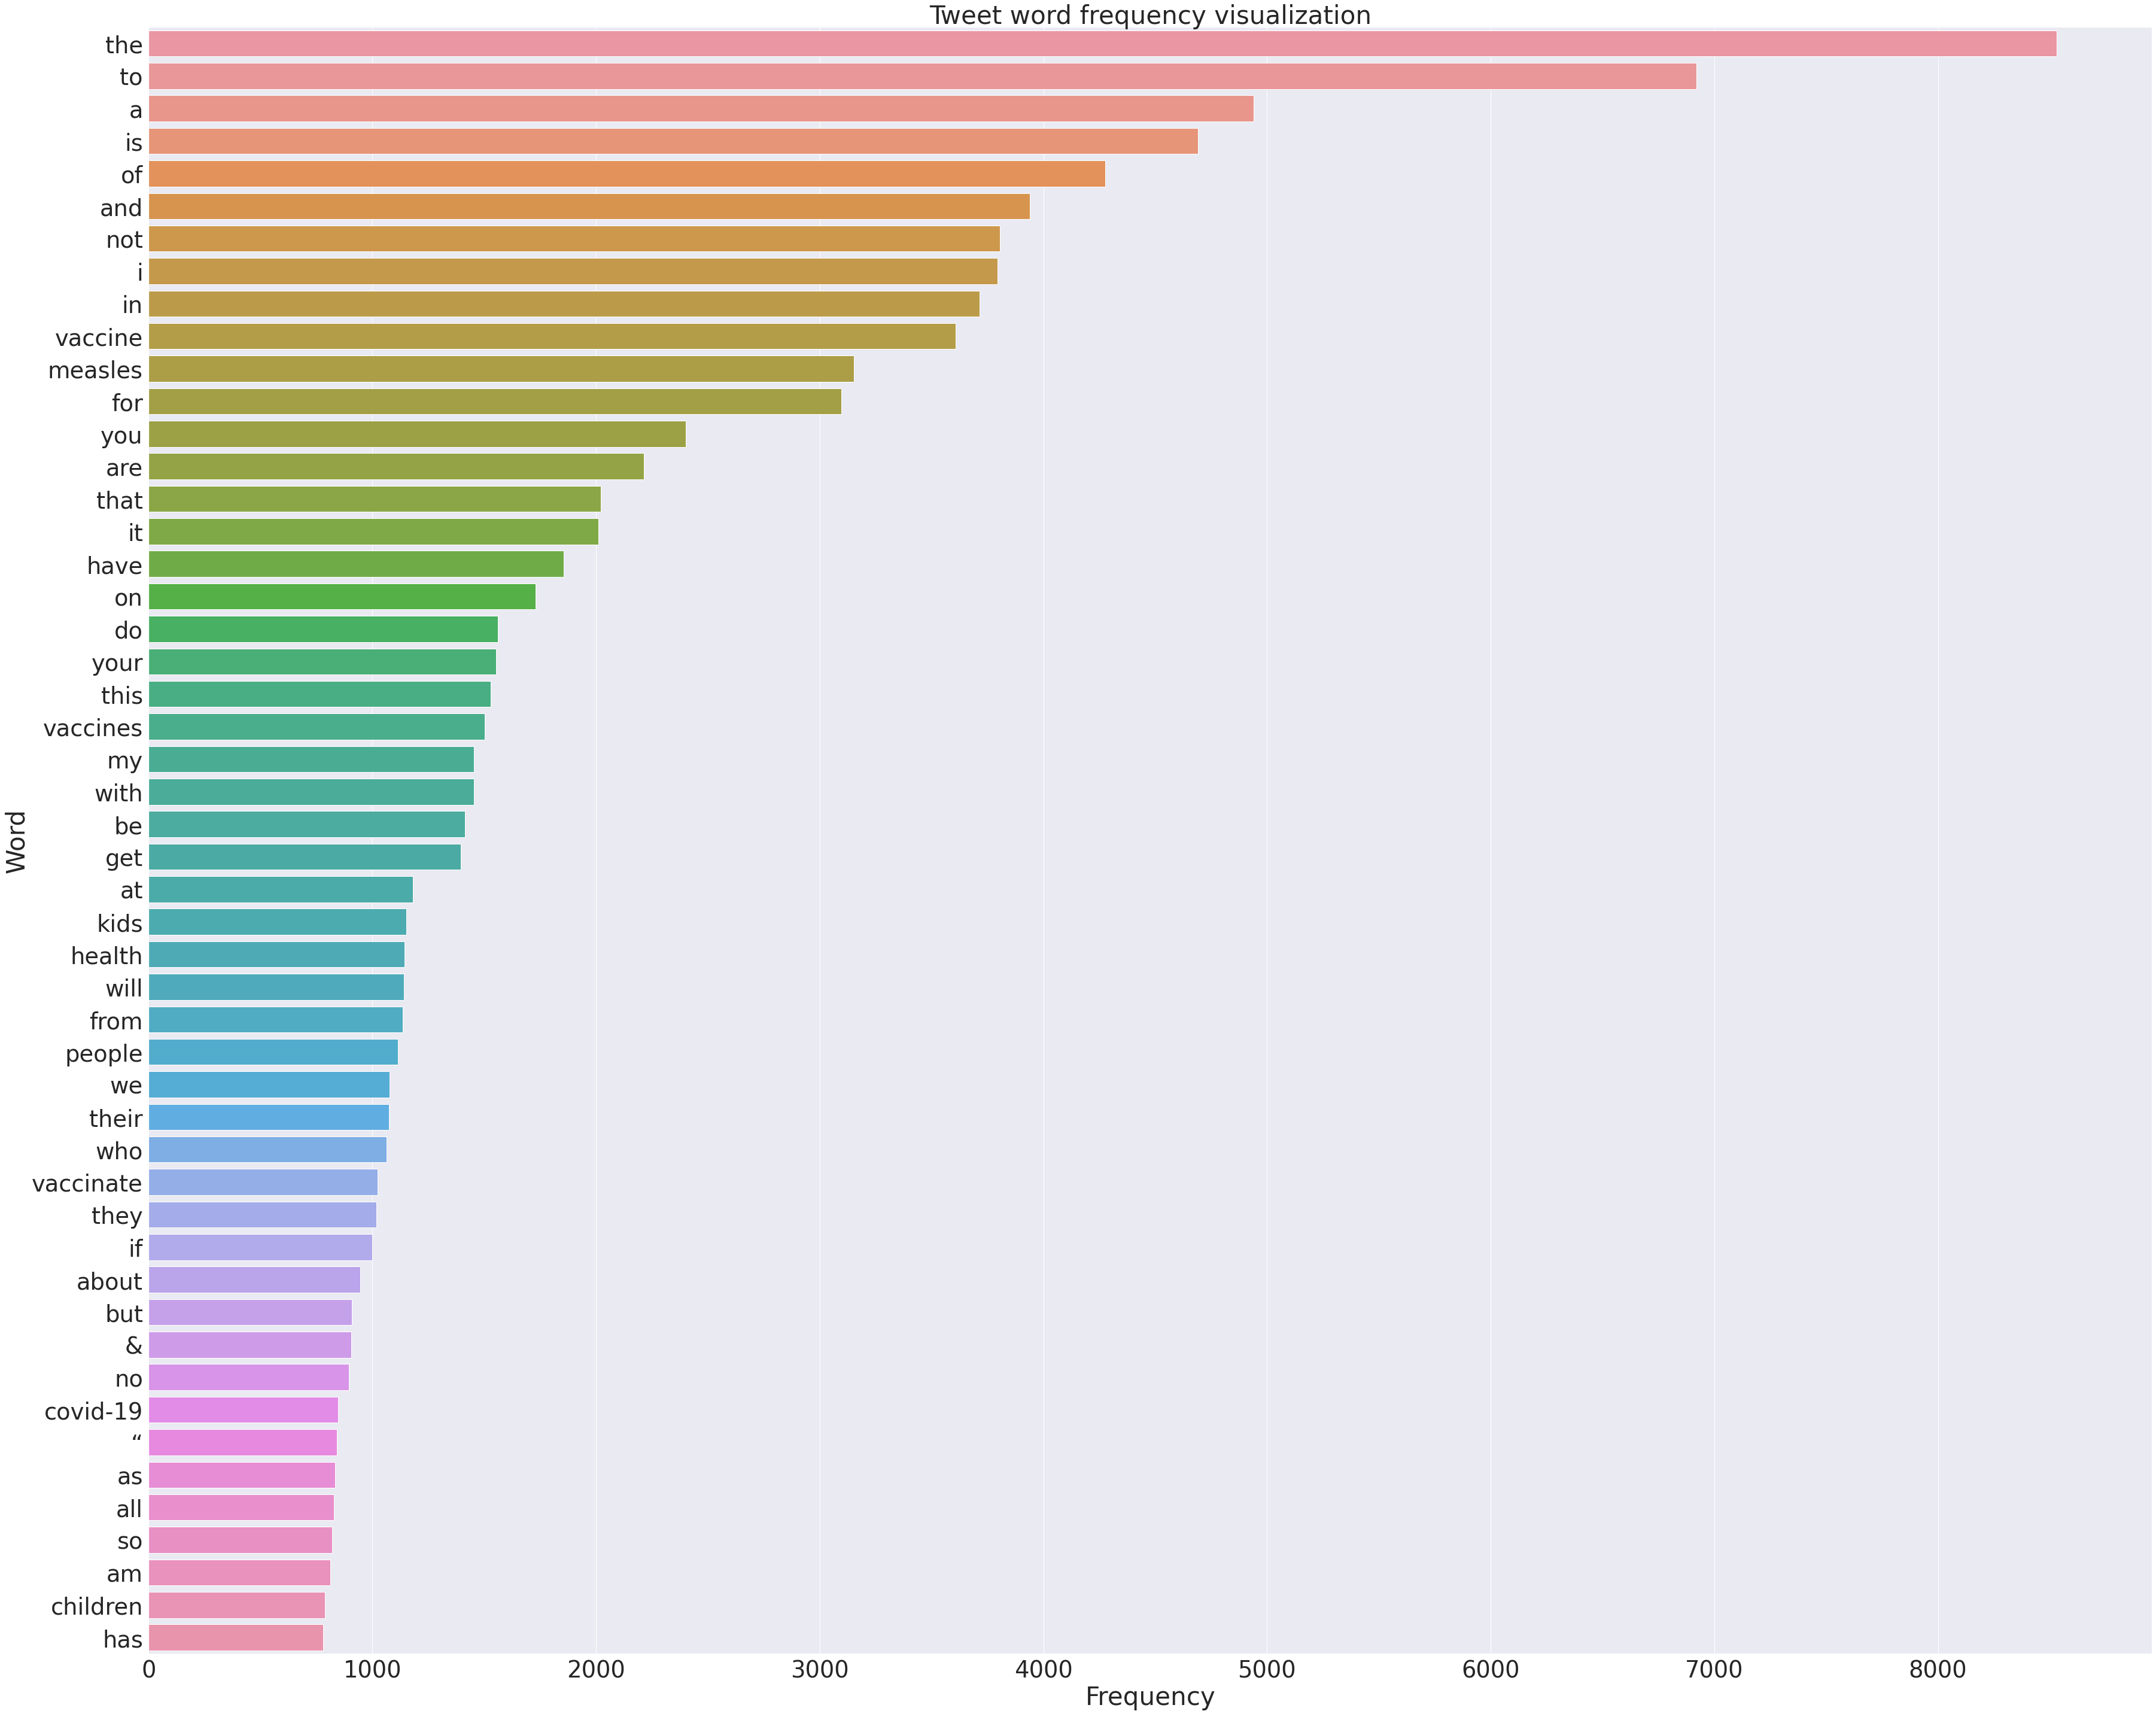

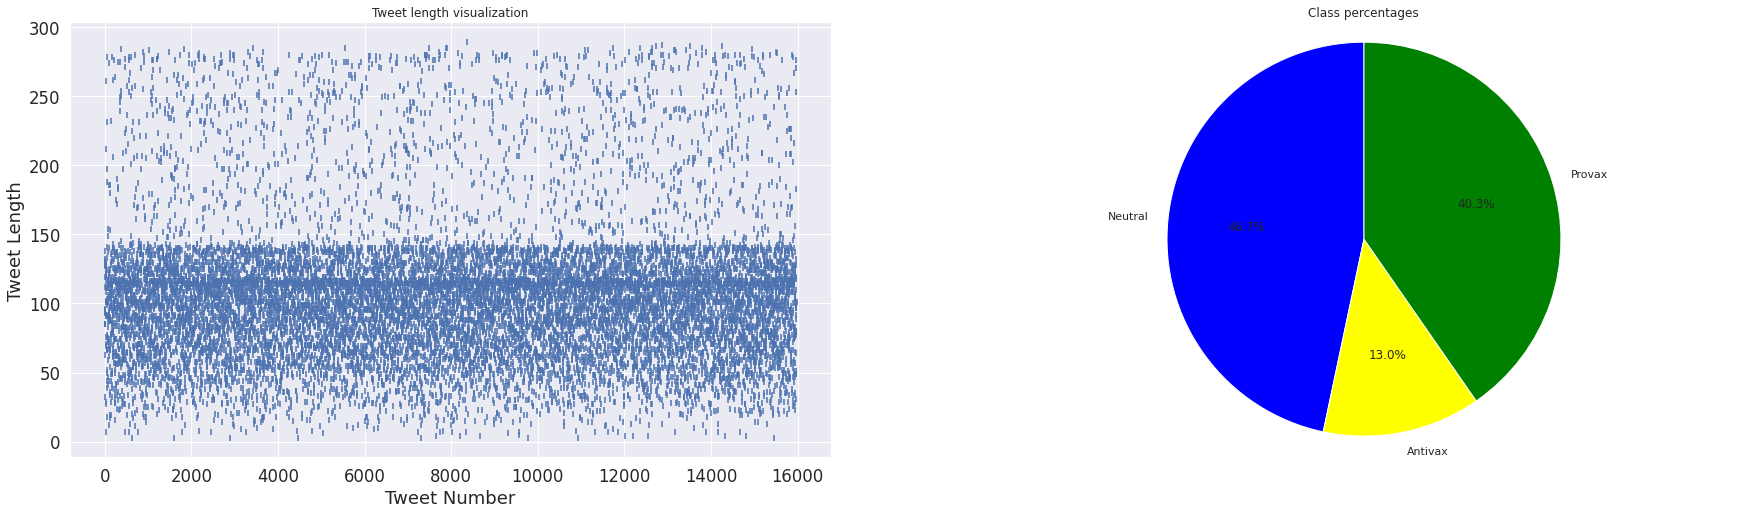

Dataset size: 15976
Average length of tweets: 104.919755


In [ ]:
# Visualization of the most common words and some other stats (for better insights)
def tweetStatistics(tweet_df, class_map):
  tweets = tweet_df['tweet'].tolist()
  all_words = []
  tweet_lens = []
  for tweet in tweets:
    tweet_lens.append(len(tweet))
    for word in tweet.split():
      all_words.append(word)
  # Using pandas to merge the word column and the frequency column for seaborn barplot
  word_freq = pd.DataFrame(Counter(all_words).items(), columns = ['Word','Frequency']).sort_values(by = 'Frequency', ascending = False)
  figure = plt.figure()
  figure.set_figwidth(60)
  figure.set_figheight(50)
  sns.set(font_scale = 3.5)
  bar = sns.barplot(x = 'Frequency', y = 'Word', data = word_freq.head(50))
  plt.title('Tweet word frequency visualization')
  plt.show()

  # Grouping the next plots
  sns.set(font_scale = 1.5)
  fig, axes = plt.subplots(1, 2)
  fig.set_figheight(8)
  fig.set_figwidth(30)
  
  # Tweet lengths
  sns.set(style='darkgrid')

  axes[0].scatter(range(0, len(tweets)), [len(tweet) for tweet in tweets], marker = "|")
  axes[0].set_xlabel('Tweet Number')
  axes[0].set_ylabel('Tweet Length')
  axes[0].set_title('Tweet length visualization')

  # Tweet class percentages
  class_stats = tweet_df.groupby(['label']).count().reset_index()
  class_stats['label'] = class_stats['label'].apply(lambda x: class_map[x])
  axes[1].pie(class_stats['tweet'].tolist(), labels = class_stats['label'].tolist(), colors = ['blue', 'yellow', 'green'], startangle = 90, autopct ='%1.1f%%')
  axes[1].axis('equal')
  axes[1].set_title('Class percentages')
  
  plt.show()
  sns.set(font_scale = 1)

  print('Dataset size: %d' % len(tweets))
  print('Average length of tweets: %f' % (sum(tweet_lens) / len(tweet_lens)))

tweetStatistics(training_set, {0: 'Neutral', 1: 'Antivax', 2: 'Provax'})



##**Fine tuning Bert for sentiment analysis**

Checking for **GPU availability**. GPU is a very powerful resource for running similar tasks which use deep neural architectures like transformers

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on GPU/Cuda' if torch.cuda.is_available() else 'Running on CPU')

Running on GPU/Cuda


Useful functions for  **perfomance visualization**. These functions are used for plotting **confusion matrices**, **learning curves** (loss vs epochs)  and **roc curves**

In [ ]:
def plotConfusionMatrix(matrix, title, ax, targets = None):
    sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = "d", ax = ax)
    ax.set_title(title + '\n');
    if targets is None:
      ax.xaxis.set_ticklabels(['False', 'True'])
      ax.yaxis.set_ticklabels(['False', 'True'])
    else:
      ax.xaxis.set_ticklabels(targets)
      ax.yaxis.set_ticklabels(targets)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10, labelbottom = False, bottom = False, top = False, labeltop = True)

def plotConfusionMatrices(targets, class_confusion_matrices, glob_confusion_matrix = None):
    if glob_confusion_matrix is not None:
      fig, axes = plt.subplots(1, len(targets) + 1)
    else:
      fig, axes = plt.subplots(1, len(targets))

    fig.set_figheight(4)
    fig.set_figwidth(20)
    i = 0
    for matrix, target in zip(class_confusion_matrices, targets):
      plotConfusionMatrix(matrix, 'Confusion Matrix for ' + target, axes[i])
      i += 1
      print()

    if glob_confusion_matrix is not None:
      plotConfusionMatrix(glob_confusion_matrix, 'Global Confusion Matrix', axes[-1], targets)
    
    plt.tight_layout()
    plt.show()


def plotLearningCurves(x_axis, y_axis, x_label, y_label, curve_ids, ax, legend_loc = 'lower right', x_best = None, y_best = None):
  if x_best is not None and y_best is not None:
    ax.annotate('Early Stopping Checkpoint ' + str(x_best), xy = (x_best, y_best), arrowprops = dict(facecolor = 'black', shrink = 0.05))
  for y, id in zip(y_axis, curve_ids):
    ax.plot(x_axis, y, label = id, linewidth = 4)
  ax.set_title('Learning Curves')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.legend(loc = legend_loc)
 

def plotRocCurves(fpr, tpr, roc_auc, n_classes, lw = 2):
  fig = plt.figure()
  plt.plot(
      fpr['micro'],
      tpr['micro'],
      label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
      color = 'deeppink',
      linestyle = ':',
      linewidth = 4,
  )

  plt.plot(
      fpr['macro'],
      tpr['macro'],
      label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
      color = 'navy',
      linestyle = ':',
      linewidth = 4,
  )

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color = color,
          lw = lw,
          label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], 'k--', lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')
  plt.legend(loc = 'lower right')
  fig.set_figheight(10)
  fig.set_figwidth(10)
  plt.show()


Popular **learning rate scheldulers.** **Linear warmup** schelduler is the most used by Bert 

In [ ]:
scheldulers = {
  'Exponential': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.1 ** (epoch / step)), # Initial lr* 0.1^(t/step)
  'Power': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (1 + epoch / step)), # Initial lr/ (1 + t/step)
  'Piecewise': lambda optimizer, milestones:  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = 0.1), # lr for 1 <= epoch < m1, lr*0.1 for m1 <= epoch < m2 ...
  'Performance': lambda optimizer, patience, factor : torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = patience, factor = factor),
  'OneCycle': lambda optimizer, steps_per_epoch, epochs, max_lr : torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = max_lr, anneal_strategy = 'linear', steps_per_epoch = steps_per_epoch, epochs = epochs),
  'LinearWarmup': get_linear_schedule_with_warmup
}

Some useful **building blocks** are specified in order to help with the development of the actual Bert model. At first, the initial tweet datasets must be **transformed** to a format that Bert "understands" (e.g token ids, segment ids, attention mask). For that reason a new **custom dataset** is created that stores all the encoded tweets into some records. The encoding is achieved using the encode for Bert method. This method performs the **tokenization** and the **truncation** to produce the **input tokens** and also creates the **segment ids** and the **attention mask** from the extracted tokens. But the input lengths might differ and some padding must also be applied. In order to reduce **memory space** and **excecution time** (and better results) some external functions are specified to apply the **padding dynamically**. Dynamic padding adds some 0s to all the above encodings up to the **longest length** in the currently processed by the model batch.

In [ ]:
# Custom dataset for tweets
class BertTweetDataset(torch.utils.data.Dataset):
  # A tweet record factory/generator 
  BertTweetRecord = namedtuple('BertTweetRecord', ['input_ids', 'token_type_ids', 'attention_mask', 'label'])
  
  tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

  def __init__(self, tweets, labels, max_length = None):
    self.tweet_records = []
    self.max_length = max_length

    for i in range(len(tweets)):
      self.add_item(tweets[i], labels[i])
      
  def __len__(self):
    return len(self.tweet_records)

  def __getitem__(self, idx):
    return self.tweet_records[idx]

  def add_item(self, tweet, tweet_label):
    record = BertTweetDataset.createBertTweetRecord(tweet, tweet_label, self.max_length)
    self.tweet_records.append(record)
  
  @staticmethod
  def encodeTweetForBert(tweet, max_length = None):
    # Whenever max length is given then truncation is applied
    truncation = max_length is not None

    input_ids = BertTweetDataset.tokenizer.encode(tweet, add_special_tokens = True, max_length = max_length, truncation = truncation)
    # There is no a pair sentence so only one segment exists
    token_type_ids = torch.zeros(len(input_ids), dtype = torch.int64)

    # All of the tokens above are active tokens and not padding tokens
    attention_mask = torch.ones(len(input_ids), dtype = torch.int64)

    return torch.tensor(input_ids), token_type_ids, attention_mask
  
  @staticmethod
  def createBertTweetRecord(tweet, tweet_label, max_length = None):
    tweet_input_ids, tweet_token_type_ids, tweet_attention_mask = BertTweetDataset.encodeTweetForBert(tweet, max_length)
    return BertTweetDataset.BertTweetRecord(tweet_input_ids, tweet_token_type_ids, tweet_attention_mask, tweet_label)

    
def padSequence(batch, padding_value = 0): 
  max_len = max([len(x) for x in batch])
  batch_padded = []
  for x in batch:
    x_padded = [padding_value] * max_len
    x_padded[:len(x)] = x
    batch_padded.append(x_padded)
    
  return batch_padded

# Collate function that is going to be used by the Dataloader in order to add padding to each batch
def padCollate(batch, padding_value = 0):
  (batch_input_ids, batch_token_type_ids, batch_attention_masks, batch_labels) = zip(*batch)
  
  # Padding all the sequences to have equal lengths (the length is equal to the length of the longest sequence in the batch)
  # Padding is applied to the segment ids and the attention masks as well
  batch_padded_features = {'input_ids': padSequence(batch_input_ids), 
                           'token_type_ids': padSequence(batch_token_type_ids),
                           'attention_mask': padSequence(batch_attention_masks)
                          }
  
  return BatchEncoding(batch_padded_features, tensor_type = 'pt').to(device), torch.tensor(batch_labels)
          

This is the actual class of the **Bert Sentiment Classifier**. This class has been extended with some extra functionalities in order to automate all the training and evaluation process as much as possible. Initialization requires the number of classes and the pooling strategy for the classification. The most pooling strategies are based on the **embeddings of the CLS token** (e.g only the embedding of the last or second to last layer and the concatenation of the embeddings of the last four layers) that keeps the information of the whole sentence (it seems to be something like **max pooling** of the whole sentence). Also there is one strategy that **averages** all the embeddings of the second to last layer (this is also a good way to extract a sentence embedding). Furthermore, there are two functions for **training**, both supporting **gradient clipping**, but the one with the more options (stats, early stopping etc...) it is going to be used below. Moreover, these functions support **learning rate schelduling** and they call in every epoch the **batch** training submethod to train all the batches. Finally, there is one method for making predictions for any given unseen input

In [ ]:
class BertClassifier(nn.Module):

    # Different strategies for extracting the classification embedding (most of the strategies are based on the different embeddings of the CLS token)
    pooling_strategies = {'LAST_CLS', 'SECOND_TO_LAST_CLS', 'SECOND_TO_LAST_AVG', 'CONCAT_LAST_FOUR_CLS'}

    def __init__(self, num_classes = 2, pooling_strategy = 'LAST_CLS'):
        super().__init__()

        if pooling_strategy not in self.pooling_strategies:
          raise Exception('Pooling strategy can be ' + ' or '.join(self.pooling_strategies))

        self.pooling_strategy = pooling_strategy
        # Instantiate BERT model (the simple bert model is going to be used for handling the above strategies manually)
        #self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_classes, output_attentions = False, output_hidden_states = False)
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = pooling_strategy != 'LAST_CLS')
        
        bert_config = self.bert.config
        D_in = bert_config.hidden_size * 4 if self.pooling_strategy == 'CONCAT_LAST_FOUR_CLS' else bert_config.hidden_size
        dropout_rate = bert_config.classifier_dropout if bert_config.classifier_dropout is not None else bert_config.hidden_dropout_prob
        # Dropout layer that is applied right before the layer of the classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(D_in, num_classes)
        
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self, bertInputConfig):

        out = self.bert(**bertInputConfig)

        if self.pooling_strategy == 'SECOND_TO_LAST_CLS':
          pooled_output = out[2][-2][:, 0, :]
        elif self.pooling_strategy == 'SECOND_TO_LAST_AVG': # This is a good technique for creating an embedding representation for the whole sentence
          pooled_output = torch.mean(out[2][-2], dim = 1)
        elif self.pooling_strategy == 'CONCAT_LAST_FOUR_CLS':
          last_four_hidden_states = out[2][-4:]
          pooled_output = torch.cat([hidden_state[:, 0, :] for hidden_state in last_four_hidden_states], dim = -1)
        else: # DEFAULT LAST CLS
          pooled_output = out[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
            
        # Logits for the classification are returned
        return logits

    '''def forward(self, bertInputConfig):

        out = self.bert(**bertInputConfig)
            
        # Logits for the CLS token are returned
        return out[0]'''
    
    def batchTrain(self, batch_loader, optimizer, loss_fun, schelduler = None, max_clip_norm = None):
      total_loss = 0.0
      correct_preds = 0.0
      total = 0.0
      f1_scores = 0.0

      for x_batch, y_batch in tqdm(batch_loader, 'Batch Training'):
        # Gradients are restored to zero
        optimizer.zero_grad()
        
        y_pred = self(x_batch).cpu()

        loss = loss_fun(y_pred, y_batch)
        total_loss += loss.item()
        
        # Backpropagation starting from the loss calculated in this epoch
        loss.backward()
        # Gradient clipping
        if max_clip_norm is not None:
          nn.utils.clip_grad_norm_(self.parameters(), max_clip_norm)
        # Model's weights update based on the gradients calculated during backprop
        optimizer.step()

        # Some scheldulers can make steps inside the batches such as OneCycle schelduler
        if schelduler is not None:
          schelduler.step()
          #print(schelduler.state_dict())

        # Batch accuracy score calculation
        y_pred = self.softmax(y_pred)
        
        # Gathering information for calculating accuracy score
        correct_preds += torch.max(y_pred, 1)[1].eq(y_batch).sum().item()
        total += len(y_batch)

        # F1 score of the batch
        f1_scores += f1_score(y_batch.detach().numpy(), torch.max(y_pred, 1)[1].detach().numpy(), average = 'weighted')

      return [correct_preds / total, total_loss / len(batch_loader), f1_scores / len(batch_loader)] # Accuracy, Loss, F1 score (an average approximation)
    
    def batchEval(self, batch_loader, loss_fun):
          total_loss = 0.0
          correct_preds = 0.0
          total = 0.0
          f1_scores = 0.0

          with torch.no_grad():
            for x_batch, y_batch in tqdm(batch_loader, 'Batch Evaluation'):
              y_pred = self(x_batch).cpu()
                
              loss = loss_fun(y_pred, y_batch)
              total_loss += loss.item() 
              
              # Batch accuracy score calculation
              y_pred = self.softmax(y_pred)
          
              correct_preds += torch.max(y_pred, 1)[1].eq(y_batch).sum().item()
              total += len(y_batch)

              # F1 score of the batch
              f1_scores += f1_score(y_batch.detach().numpy(), torch.max(y_pred, 1)[1].detach().numpy(), average = 'weighted')
          
          return [correct_preds / total, total_loss / len(batch_loader), f1_scores / len(batch_loader)]
        
    def fineTuning(self, training_set, optimizer, loss_fun, lr_schelduler = None, max_clip_norm = None, epochs = 3, batch_size = 32):
      # Switching to training mode
      self.train()

      # Training batches
      batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = padCollate)
      
      # Creating the right schelduling function
      if lr_schelduler is not None:
        if lr_schelduler['name'] != 'Performance':
          schelduler = lr_schelduler['schelduler']
        else:
          raise Exception('Performance schelduling cannot be applied')

      for epoch in range(1, epochs + 1):
        print(f'\nEpoch: {epoch}')
        if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
          acc_score, loss_score, f1 = self.batchTrain(batch_loader, optimizer, loss_fun, schelduler, max_clip_norm)
        else:
          acc_score, loss_score, f1 = self.batchTrain(batch_loader, optimizer, loss_fun, None, max_clip_norm)
    
        # Learning rate modification for the next epoch
        if lr_schelduler is not None and lr_schelduler['epoch_step']:
          schelduler.step()
          #print(schelduler.state_dict())
        
        print(f'Accuracy = {acc_score:.5f}, Loss = {loss_score:.5f} , F1 score = {f1:.5f}')

    def fineTuningWithOptions(self, training_set, optimizer, loss_fun, validation_set = None, lr_schelduler = None, max_clip_norm = None, epochs = 3, batch_size = 32, stats = False, early_stopping_params = None):
      if validation_set is not None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        valid_losses = []
        valid_acc_scores = []
        valid_f1_scores = []
        train_losses = []
        train_acc_scores = []
        train_f1_scores = []
        best_score = float('inf')
        best_iter = 1
        counter = 0
        epoch = 1

        # Training batches
        training_batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = padCollate)

        # Validation batches
        validation_batch_loader = torch.utils.data.DataLoader(validation_set, batch_size = batch_size, collate_fn = padCollate)

        # Creating the right schelduling function
        if lr_schelduler is not None:
          schelduler = lr_schelduler['schelduler']
        
        for epoch in range(1, epochs + 1): 
          if stats: 
            print(f'\nEpoch: {epoch}')
          # Switching to training mode
          self.train()
          # Batch training and calculation of the average training batch scores (accuracy score, loss, f1 score)
          if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
            train_acc_score, train_loss, train_f1_score = self.batchTrain(training_batch_loader, optimizer, loss_fun, schelduler, max_clip_norm)
          else:
            train_acc_score, train_loss, train_f1_score = self.batchTrain(training_batch_loader, optimizer, loss_fun, None, max_clip_norm)

          train_acc_scores.append(train_acc_score)
          train_losses.append(train_loss)
          train_f1_scores.append(train_f1_score)

          # Switching to evaluation mode
          self.eval()
          # Calculation of validation batch scores
          valid_acc_score, valid_loss, valid_f1_score =  self.batchEval(validation_batch_loader, loss_fun)

          valid_acc_scores.append(valid_acc_score)
          valid_losses.append(valid_loss)
          valid_f1_scores.append(valid_f1_score)

          if valid_loss < best_score:
            best_score = valid_loss
            best_iter = epoch
            counter = 0
          else: 
            counter += 1

          # If validation set starts increasing by reaching a small patience then maybe the model starts to overfit. So model training has to stop as soon as possible
          if early_stopping_params is not None and counter == early_stopping_params['patience']:
            break
          
          # Learning rate modification for the next epoch
          if lr_schelduler is not None:
            if lr_schelduler['name'] == 'Performance': # Validation loss must be passed to the performance schelduler
              schelduler.step(valid_loss)
            elif lr_schelduler['epoch_step']:
              schelduler.step()
            #print(schelduler.state_dict())

          if stats: 
            print(f'Training: Accuracy = {train_acc_score:.5f}, Loss = {train_loss:.5f} , F1 score = {train_f1_score:.5f}')
            print(f'Validation: Accuracy = {valid_acc_score:.5f}, Loss = {valid_loss:.5f} , F1 score = {valid_f1_score:.5f}')
        
        if stats:
          # Learning curve plots
          fig, axes = plt.subplots(1, 2)
          fig.set_figheight(5)
          fig.set_figwidth(25)
          plotLearningCurves(list(range(1, epoch + 1)), [valid_acc_scores, train_acc_scores], 'Number of Iterations', 'Accuracy', ['validation', 'training'], axes[0], 'lower right')
          plotLearningCurves(list(range(1, epoch + 1)), [valid_losses, train_losses], 'Number of Iterations', 'Loss', ['validation', 'training'], axes[1], 'upper right', best_iter, best_score)
          plt.show()
          
          return [train_acc_scores, valid_acc_scores, train_f1_scores, valid_f1_scores, train_losses, valid_losses]
          
      elif validation_set is None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        raise Exception('Validation set must not be None in order to calculate stats or to do early stopping or to do performance schelduling')
      else: 
        self.fineTuning(training_set, optimizer, loss_fun, lr_schelduler, max_clip_norm, epochs, batch_size)
    
    def predict(self, X, proba = False):
      # Switching to evaluation mode
      self.eval()
      with torch.no_grad():
          # Model computes the scores of each class so softmax function must be applied
          y_pred = self.softmax(self(X)).cpu()

          if proba:  # Probabilities are returned
            return y_pred
          else: # Class estimations are returned
            return torch.max(y_pred, 1)[1]


Functions for **fine tuning** using a custom made **grid search** and for a final **model evaluation** in batches (including all score measurements as well as the creation of confusion matrices for all classes together and for each class as well and also the creation of the roc curves in such a way that the sklearn library recommends)

In [ ]:
# Implemented in such a way that sklearn recommends to create ROC curves
def rocCurves(y_test, y_pred, targets):
  fpr = {}
  tpr = {}
  roc_auc = {}
  n_classes = len(targets)

  # Actual labels must be one-hot encoded
  encoder = OneHotEncoder(sparse = False, dtype = int)
  y_test = encoder.fit_transform(y_test.reshape(len(y_test), 1))

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
  
  # False positive rates aggregation
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # All ROC curves are interpolated
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  
  plotRocCurves(fpr, tpr, roc_auc, n_classes)

def modelEvaluation(clf, test_set, targets, batch_size = 512, cm_plot = False, roc_plot = False):
  batch_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, collate_fn = padCollate)
  y_pred = torch.LongTensor()
  y_test = torch.LongTensor()

  for x_batch, y_batch in batch_loader:
    y_pred = torch.cat([y_pred, clf.predict(x_batch)])
    y_test = torch.cat([y_test, y_batch])

  # All metrics in one
  report = classification_report(y_test.detach().numpy(), y_pred.detach().numpy(), target_names = targets , digits = 5, output_dict = True)
  print(pd.DataFrame(report).transpose().drop(['support'], axis = 1).drop(['accuracy'], axis = 0).to_string())
  display(Markdown(f'**Accuracy: {report["accuracy"]:.5f}** \n' ))
  if cm_plot:
    class_confusion_matrices = multilabel_confusion_matrix(y_test, y_pred, labels = [i for i in range(len(targets))])
    glob_confusion_matrix = confusion_matrix(y_test, y_pred, labels = [i for i in range(len(targets))])
    plotConfusionMatrices(targets, class_confusion_matrices, glob_confusion_matrix)
  if roc_plot:
    # Roc curves need the probabilities of each class
    y_pred = torch.LongTensor()
    for x_batch, y_batch in batch_loader:
      y_pred = torch.cat([y_pred, clf.predict(x_batch, proba = True)])
    rocCurves(y_test, y_pred, targets)
  return report

def customGridSearch(param_grid, training_set, validation_set):
  i = 1
  for batch_size in param_grid['batch_sizes']:
    for learning_rate in param_grid['learning_rates']:
      for pooling_strategy in param_grid['pooling_strategies']:
              
        model = BertClassifier(len(param_grid['classes']), pooling_strategy).to(device)
        
        # AdamW is an improved version of Adam to better handle the weight decay factor (thats why it is prefered against Adam)
        # Default values of AdamW are the same with the values used at the pretraining phase of Bert
        optimizer = torch.optim.AdamW(model.parameters(), learning_rate['val'], weight_decay = 1e-2)
        loss_function = nn.CrossEntropyLoss()

        schelduler = None
        # Creation of the schelduler with some default values (e.g steps, etc..)
        if learning_rate['schelduler']:
          total_steps = math.ceil(len(training_set) / batch_size) * param_grid['epochs']
          if learning_rate['schelduler'] == 'Exponential':
            schelduler = {'name':  'Exponential', 'schelduler': scheldulers['Exponential'](optimizer, 5), 'epoch_step': True}
          if learning_rate['schelduler'] == 'Power':
            schelduler = {'name':  'Power', 'schelduler': scheldulers['Power'](optimizer, 5), 'epoch_step': True}
          if learning_rate['schelduler'] == 'Piecewise':
            schelduler = {'name':  'Piecewise', 'schelduler': scheldulers['Piecewise'](optimizer, [0.2 * param_grid['epochs'], 0.5 * param_grid['epochs'], 0.8 * param_grid['epochs']]), 'epoch_step': True} 
          if learning_rate['schelduler'] == 'Performance':
            schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}
          if learning_rate['schelduler'] == 'OneCycle':
            schelduler = {'name':  'OneCycle', 'schelduler': scheldulers['OneCycle'](optimizer, total_steps / param_grid['epochs'], param_grid['epochs'], learning_rate['val'] * 100), 'epoch_step': False}
          if learning_rate['schelduler'] == 'Linear': # Linear learning rate decay (thats why the warmup steps are 0) is the most popular schelduler and most used in many common tasks
            schelduler = {'name':  'Linear', 'schelduler': scheldulers['LinearWarmup'](optimizer, num_warmup_steps = 0, num_training_steps = total_steps), 'epoch_step': False}
          if learning_rate['schelduler'] == 'LinearWarmup': # Linear warmup 10% of the total steps 
            schelduler = {'name':  'LinearWarmup', 'schelduler': scheldulers['LinearWarmup'](optimizer, num_warmup_steps = 0.1 * total_steps, num_training_steps = total_steps), 'epoch_step': False} 

        curr_grid = f'Grid Search {i} Batch size: {batch_size}, Learning rate: {learning_rate["val"]}, Schelduler: {learning_rate["schelduler"] if schelduler is not None else None}, Pooling strategy: {" ".join(pooling_strategy.split("_"))}'
        display(Markdown('**' + curr_grid + '**'))
        
        i += 1
        # Timekeeping the training process
        timestamp_start = time.time()
        model.fineTuningWithOptions(training_set, optimizer, loss_function, validation_set, schelduler, param_grid['max_clip_norm'], param_grid['epochs'], batch_size, True, None)
        timestamp_end = time.time()
        # Model evaluation
        scores = modelEvaluation(model, validation_set, param_grid['classes'], 512)
        print(f'\nTotal time: {timestamp_end - timestamp_start:.2f} seconds')


## **Model fine tuning and evaluation section**

**Training** and **validation datasets** creation including all the encoded Bert inputs of the tweets. Also a max length value is defined for **length truncation** according to the tweet length statistics section above. This value is specified properly in order not to lose much information

In [ ]:
max_tweet_length = 128
bert_training_set = BertTweetDataset(training_set['tweet'].tolist(), training_set['label'].tolist(), max_tweet_length)
bert_validation_set = BertTweetDataset(validation_set['tweet'].tolist(), validation_set['label'].tolist(), max_tweet_length)

### **Evaluation of the basic/common hyperparameter options for fine tuning**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 1 Batch size: 16, Learning rate: 5e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.10it/s]


Training: Accuracy = 0.71219, Loss = 0.67113 , F1 score = 0.69654
Validation: Accuracy = 0.77301, Loss = 0.57413 , F1 score = 0.76341

Epoch: 2


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.09it/s]


Training: Accuracy = 0.82430, Loss = 0.46344 , F1 score = 0.82113
Validation: Accuracy = 0.76249, Loss = 0.56680 , F1 score = 0.75707

Epoch: 3


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.11it/s]


Training: Accuracy = 0.90242, Loss = 0.29048 , F1 score = 0.90129
Validation: Accuracy = 0.76424, Loss = 0.72692 , F1 score = 0.76456


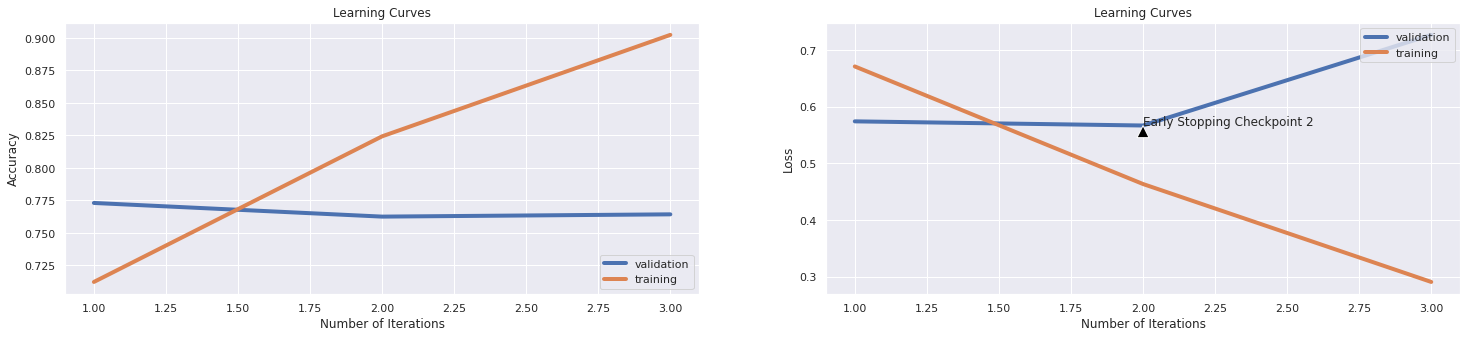

              precision    recall  f1-score
neutral        0.842051  0.770892  0.804902
antivax        0.650000  0.614865  0.631944
provax         0.721519  0.804560  0.760780
macro avg      0.737857  0.730106  0.732542
weighted avg   0.768494  0.764242  0.764660


**Accuracy: 0.76424** 



Total time: 1146.16 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 2 Batch size: 16, Learning rate: 3e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.09it/s]


Training: Accuracy = 0.71720, Loss = 0.66771 , F1 score = 0.69903
Validation: Accuracy = 0.76819, Loss = 0.55922 , F1 score = 0.75978

Epoch: 2


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.10it/s]


Training: Accuracy = 0.82474, Loss = 0.44861 , F1 score = 0.82172
Validation: Accuracy = 0.77695, Loss = 0.58881 , F1 score = 0.77241

Epoch: 3


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.07it/s]


Training: Accuracy = 0.90548, Loss = 0.27458 , F1 score = 0.90429
Validation: Accuracy = 0.76424, Loss = 0.65958 , F1 score = 0.76128


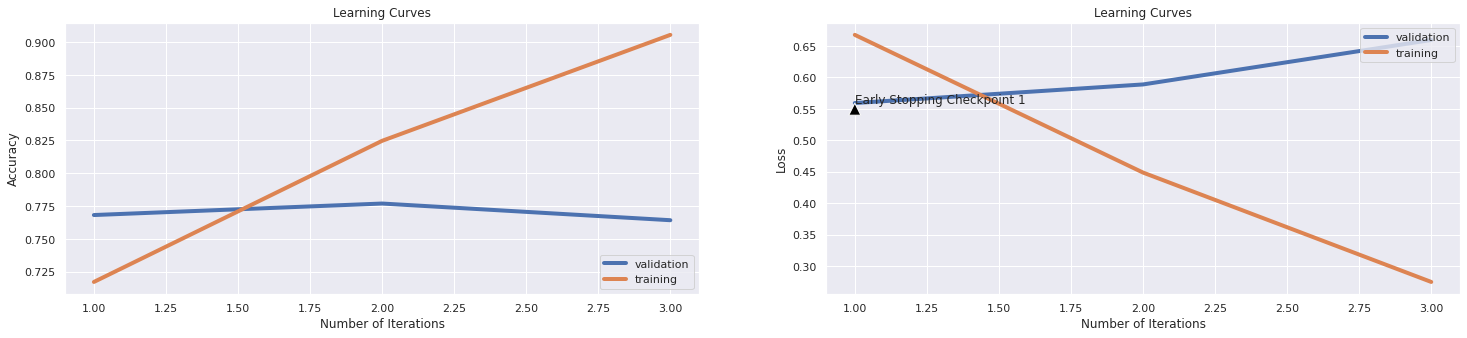

              precision    recall  f1-score
neutral        0.769428  0.846009  0.805903
antivax        0.700758  0.625000  0.660714
provax         0.776860  0.714441  0.744344
macro avg      0.749015  0.728483  0.736987
weighted avg   0.763520  0.764242  0.762226


**Accuracy: 0.76424** 



Total time: 1147.28 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 3 Batch size: 16, Learning rate: 2e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.09it/s]


Training: Accuracy = 0.71207, Loss = 0.67321 , F1 score = 0.69396
Validation: Accuracy = 0.76950, Loss = 0.56377 , F1 score = 0.76153

Epoch: 2


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.08it/s]


Training: Accuracy = 0.82104, Loss = 0.45908 , F1 score = 0.81807
Validation: Accuracy = 0.77651, Loss = 0.58264 , F1 score = 0.77700

Epoch: 3


Batch Evaluation: 100%|██████████| 143/143 [00:15<00:00,  9.10it/s]


Training: Accuracy = 0.89553, Loss = 0.29524 , F1 score = 0.89445
Validation: Accuracy = 0.76731, Loss = 0.68169 , F1 score = 0.76691


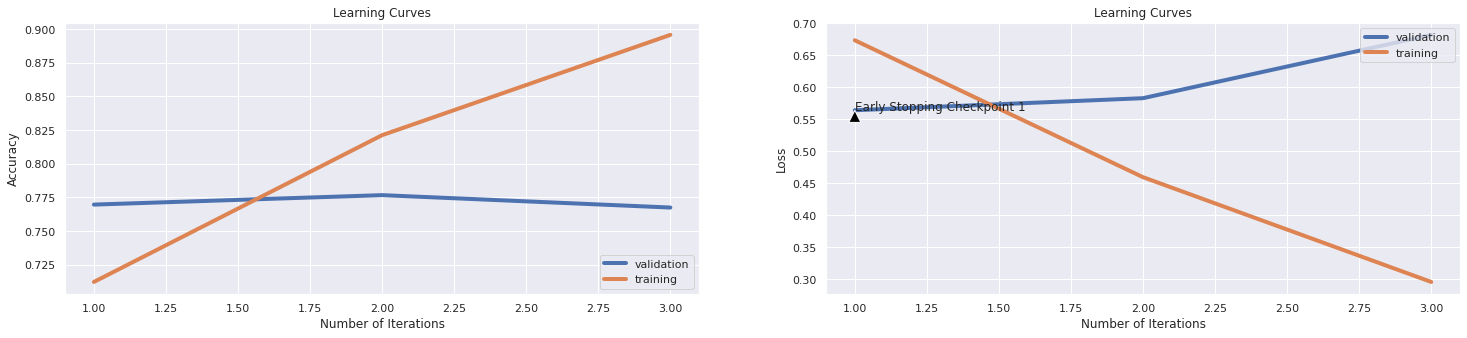

              precision    recall  f1-score
neutral        0.801276  0.825352  0.813136
antivax        0.669118  0.614865  0.640845
provax         0.755750  0.749186  0.752454
macro avg      0.742048  0.729801  0.735478
weighted avg   0.765760  0.767309  0.766297


**Accuracy: 0.76731** 



Total time: 1150.52 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 4 Batch size: 32, Learning rate: 5e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.31it/s]


Training: Accuracy = 0.72039, Loss = 0.65945 , F1 score = 0.70347
Validation: Accuracy = 0.76556, Loss = 0.56697 , F1 score = 0.76866

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.82818, Loss = 0.44023 , F1 score = 0.82536
Validation: Accuracy = 0.77432, Loss = 0.57952 , F1 score = 0.77151

Epoch: 3


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.91118, Loss = 0.25459 , F1 score = 0.91052
Validation: Accuracy = 0.77388, Loss = 0.66783 , F1 score = 0.77286


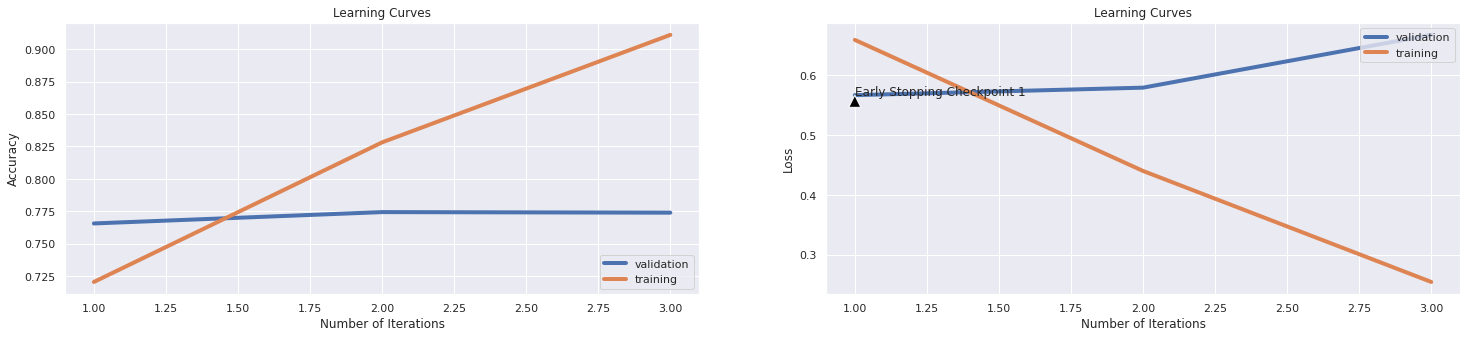

              precision    recall  f1-score
neutral        0.837095  0.800939  0.818618
antivax        0.693227  0.587838  0.636197
provax         0.730237  0.802389  0.764615
macro avg      0.753520  0.730389  0.739810
weighted avg   0.775307  0.773883  0.773161


**Accuracy: 0.77388** 



Total time: 1055.60 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 5 Batch size: 32, Learning rate: 3e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.28it/s]


Training: Accuracy = 0.69836, Loss = 0.69553 , F1 score = 0.67416
Validation: Accuracy = 0.75942, Loss = 0.57454 , F1 score = 0.75751

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.29it/s]


Training: Accuracy = 0.81854, Loss = 0.46567 , F1 score = 0.81648
Validation: Accuracy = 0.77958, Loss = 0.56353 , F1 score = 0.77687

Epoch: 3


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.89797, Loss = 0.28329 , F1 score = 0.89712
Validation: Accuracy = 0.77082, Loss = 0.63777 , F1 score = 0.76829


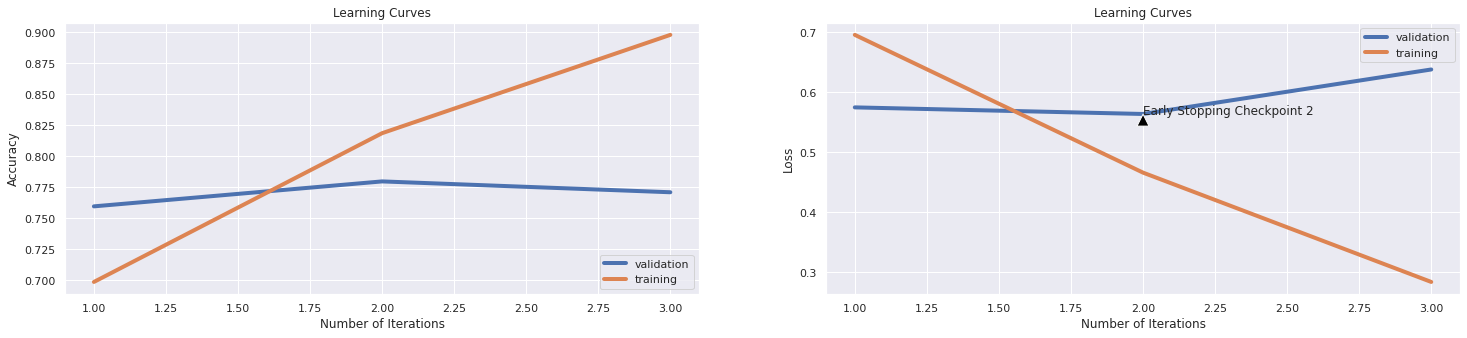

              precision    recall  f1-score
neutral        0.798731  0.827230  0.812731
antivax        0.706349  0.601351  0.649635
provax         0.755124  0.760043  0.757576
macro avg      0.753401  0.729542  0.739980
weighted avg   0.769148  0.770815  0.769315


**Accuracy: 0.77082** 



Total time: 1056.87 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 6 Batch size: 32, Learning rate: 2e-05, Schelduler: None, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.30it/s]


Training: Accuracy = 0.71038, Loss = 0.68465 , F1 score = 0.69071
Validation: Accuracy = 0.75898, Loss = 0.59039 , F1 score = 0.75073

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.28it/s]


Training: Accuracy = 0.80821, Loss = 0.48490 , F1 score = 0.80572
Validation: Accuracy = 0.77783, Loss = 0.54404 , F1 score = 0.77885

Epoch: 3


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.88376, Loss = 0.32556 , F1 score = 0.88328
Validation: Accuracy = 0.76775, Loss = 0.64144 , F1 score = 0.76922


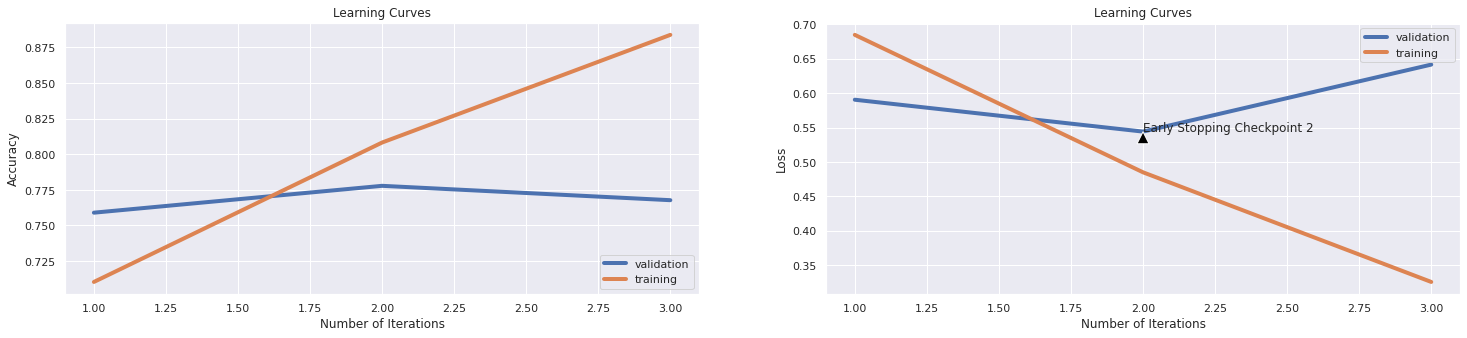

              precision    recall  f1-score
neutral        0.865385  0.760563  0.809595
antivax        0.639175  0.628378  0.633731
provax         0.716588  0.820847  0.765182
macro avg      0.740383  0.736596  0.736169
weighted avg   0.775989  0.767748  0.768859


**Accuracy: 0.76775** 



Total time: 1058.21 seconds


In [ ]:
param_grid = {
  'batch_sizes': [16, 32],
  'learning_rates': [{'val': val, 'schelduler': None} for val in [5e-5, 3e-5, 2e-5]],
  'classes': ['neutral', 'antivax', 'provax'],
  'pooling_strategies': ['LAST_CLS'],
  'max_clip_norm': 1.0,
  'epochs': 3,
}

customGridSearch(param_grid, bert_training_set, bert_validation_set)

### **Evaluation of the effectiveness of the linear schelduling (with and without warmup)**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 1 Batch size: 32, Learning rate: 3e-05, Schelduler: Linear, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.33it/s]


Training: Accuracy = 0.71845, Loss = 0.65757 , F1 score = 0.70133
Validation: Accuracy = 0.76906, Loss = 0.57136 , F1 score = 0.77011

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.33it/s]


Training: Accuracy = 0.83056, Loss = 0.44425 , F1 score = 0.82869
Validation: Accuracy = 0.77695, Loss = 0.56938 , F1 score = 0.77740


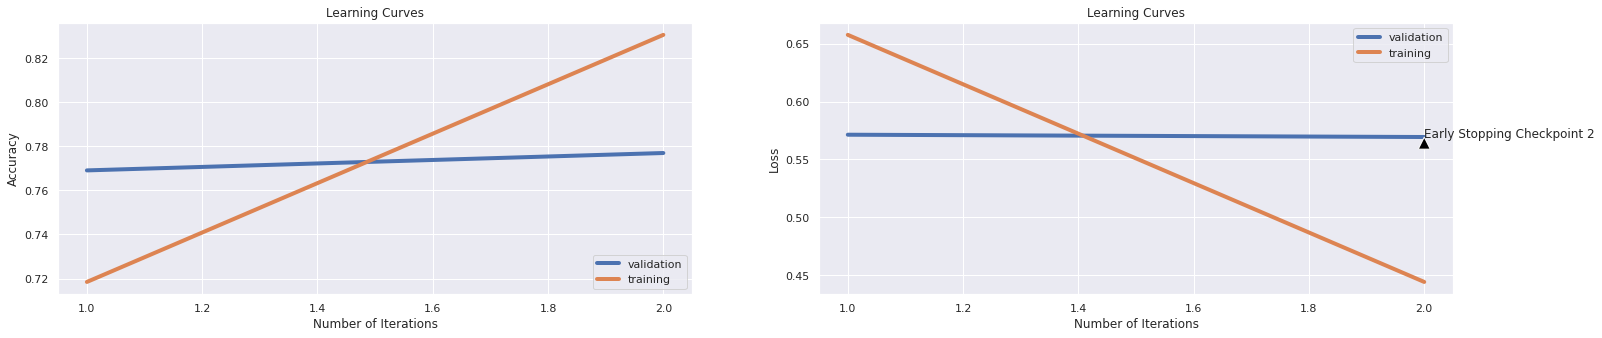

              precision    recall  f1-score
neutral        0.858871  0.800000  0.828391
antivax        0.657692  0.577703  0.615108
provax         0.728155  0.814332  0.768836
macro avg      0.748240  0.730678  0.737445
weighted avg   0.780020  0.776950  0.776690


**Accuracy: 0.77695** 



Total time: 703.72 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 2 Batch size: 32, Learning rate: 3e-05, Schelduler: LinearWarmup, Pooling strategy: LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.38it/s]


Training: Accuracy = 0.69529, Loss = 0.70439 , F1 score = 0.67142
Validation: Accuracy = 0.75986, Loss = 0.57281 , F1 score = 0.75666

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.33it/s]


Training: Accuracy = 0.81485, Loss = 0.47226 , F1 score = 0.81312
Validation: Accuracy = 0.77695, Loss = 0.56414 , F1 score = 0.77590


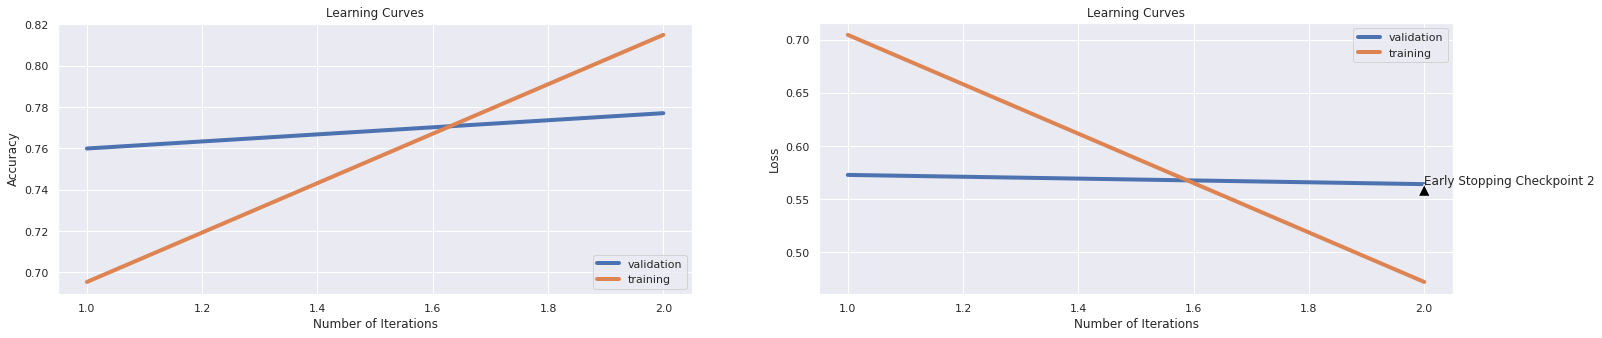

              precision    recall  f1-score
neutral        0.847507  0.814085  0.830460
antivax        0.685106  0.543919  0.606403
provax         0.727539  0.808903  0.766067
macro avg      0.753384  0.722302  0.734310
weighted avg   0.778024  0.776950  0.775409


**Accuracy: 0.77695** 



Total time: 705.48 seconds


In [ ]:
param_grid = {
  'batch_sizes': [32],
  'learning_rates': [{'val': 3e-5, 'schelduler': schelduler} for schelduler in ['Linear', 'LinearWarmup']],
  'classes': ['neutral', 'antivax', 'provax'],
  'pooling_strategies': ['LAST_CLS'],
  'max_clip_norm': 1.0,
  'epochs': 2,
}

customGridSearch(param_grid, bert_training_set, bert_validation_set)

### **Evaluation between all the different pooling strategies**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 1 Batch size: 32, Learning rate: 3e-05, Schelduler: None, Pooling strategy: SECOND TO LAST CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.37it/s]


Training: Accuracy = 0.71457, Loss = 0.66215 , F1 score = 0.69910
Validation: Accuracy = 0.74890, Loss = 0.61005 , F1 score = 0.72974

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.33it/s]


Training: Accuracy = 0.81929, Loss = 0.45117 , F1 score = 0.81673
Validation: Accuracy = 0.77432, Loss = 0.57246 , F1 score = 0.77454


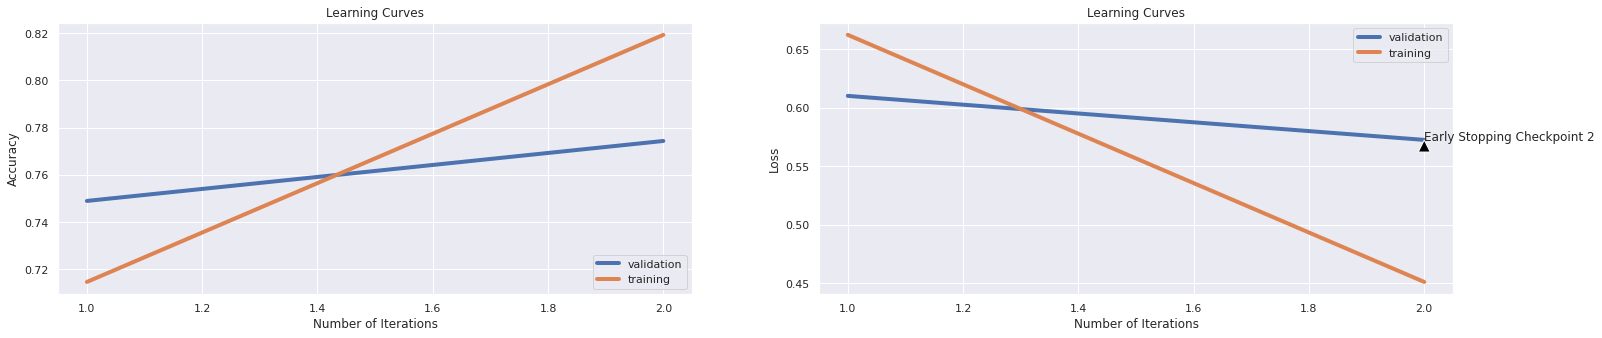

              precision    recall  f1-score
neutral        0.836399  0.811268  0.823642
antivax        0.647887  0.621622  0.634483
provax         0.745078  0.780673  0.762460
macro avg      0.743121  0.737854  0.740195
weighted avg   0.775090  0.774321  0.774413


**Accuracy: 0.77432** 



Total time: 669.22 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 2 Batch size: 32, Learning rate: 3e-05, Schelduler: None, Pooling strategy: SECOND TO LAST AVG**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.37it/s]


Training: Accuracy = 0.71751, Loss = 0.65753 , F1 score = 0.70318
Validation: Accuracy = 0.76117, Loss = 0.57169 , F1 score = 0.76156

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.36it/s]


Training: Accuracy = 0.82962, Loss = 0.43492 , F1 score = 0.82773
Validation: Accuracy = 0.77344, Loss = 0.56136 , F1 score = 0.77275


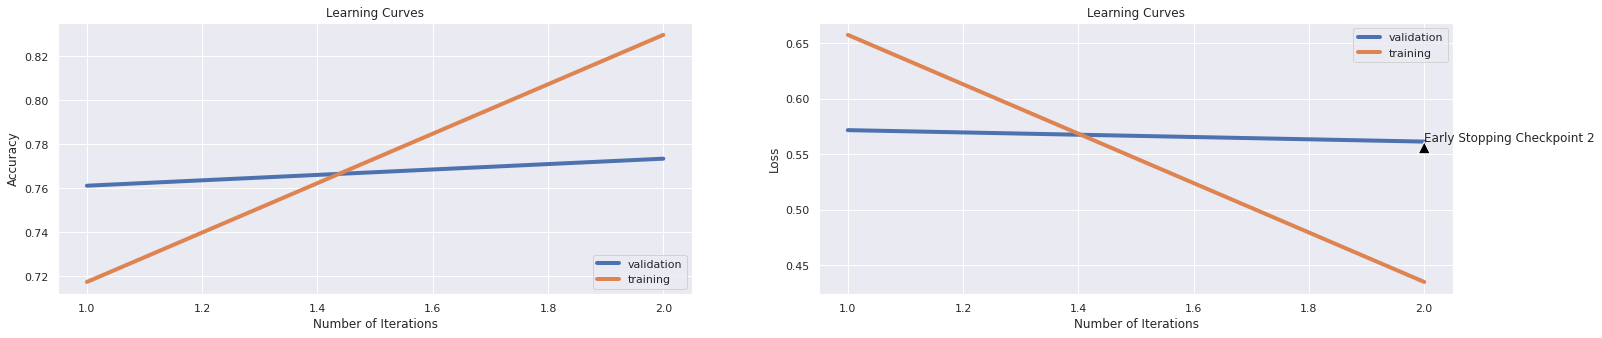

              precision    recall  f1-score
neutral        0.852227  0.790610  0.820263
antivax        0.720833  0.584459  0.645522
provax         0.721063  0.825190  0.769620
macro avg      0.764708  0.733420  0.745135
weighted avg   0.782247  0.777826  0.777158


**Accuracy: 0.77783** 



Total time: 673.62 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Grid Search 3 Batch size: 32, Learning rate: 3e-05, Schelduler: None, Pooling strategy: CONCAT LAST FOUR CLS**


Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.39it/s]


Training: Accuracy = 0.71945, Loss = 0.65560 , F1 score = 0.70409
Validation: Accuracy = 0.77344, Loss = 0.55365 , F1 score = 0.77644

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.82743, Loss = 0.44694 , F1 score = 0.82595
Validation: Accuracy = 0.76950, Loss = 0.56235 , F1 score = 0.76191


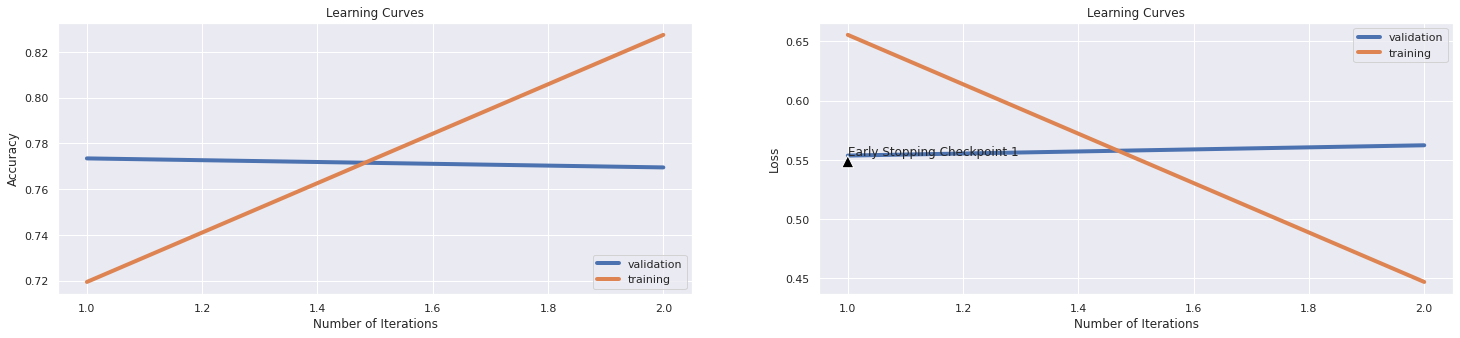

              precision    recall  f1-score
neutral        0.788428  0.857277  0.821413
antivax        0.758065  0.476351  0.585062
provax         0.748401  0.762215  0.755245
macro avg      0.764965  0.698614  0.720573
weighted avg   0.768335  0.769500  0.764050


**Accuracy: 0.76950** 



Total time: 702.99 seconds


In [ ]:
param_grid = {
  'batch_sizes': [32],
  'learning_rates': [{'val': 3e-5, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'pooling_strategies': ['SECOND_TO_LAST_CLS', 'SECOND_TO_LAST_AVG', 'CONCAT_LAST_FOUR_CLS'],
  'max_clip_norm': 1.0,
  'epochs': 2,
}

customGridSearch(param_grid, bert_training_set, bert_validation_set)

## **Best Bert Model**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 1


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.32it/s]


Training: Accuracy = 0.71319, Loss = 0.67382 , F1 score = 0.69356
Validation: Accuracy = 0.76643, Loss = 0.56466 , F1 score = 0.76815

Epoch: 2


Batch Evaluation: 100%|██████████| 72/72 [00:16<00:00,  4.34it/s]


Training: Accuracy = 0.81985, Loss = 0.45691 , F1 score = 0.81756
Validation: Accuracy = 0.78659, Loss = 0.55233 , F1 score = 0.78422


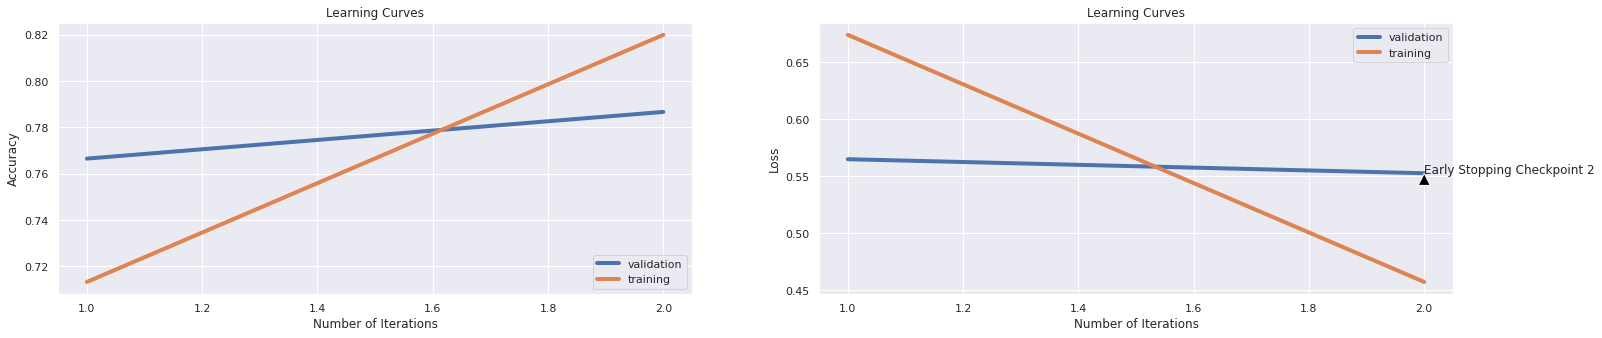

              precision    recall  f1-score
neutral        0.859000  0.806573  0.831961
antivax        0.746341  0.516892  0.610778
provax         0.727019  0.850163  0.783784
macro avg      0.777454  0.724543  0.742174
weighted avg   0.791121  0.786591  0.783827


**Accuracy: 0.78659** 


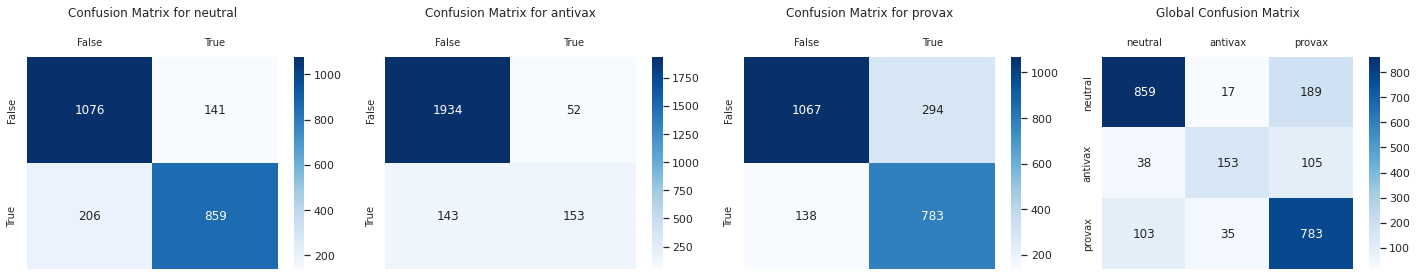

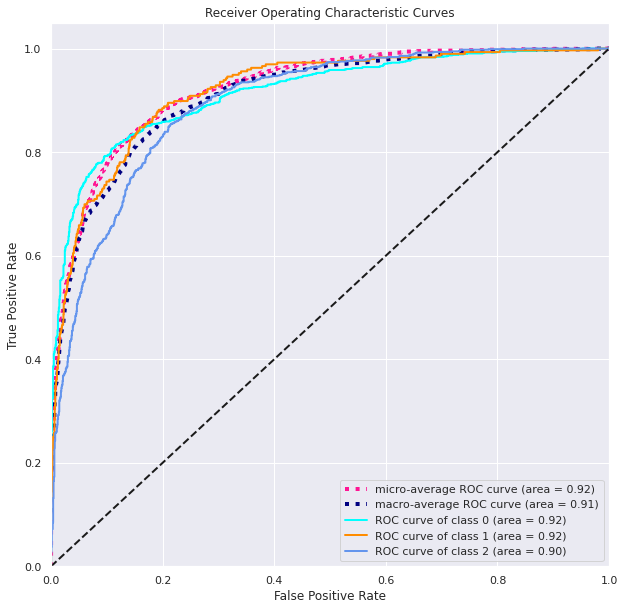

In [ ]:
classes = ['neutral', 'antivax' ,'provax']
learning_rate = 3e-5
epochs = 2
batch_size = 32
max_clip_norm = 1.0
schelduler = None
pooling_strategy = 'LAST_CLS'

model = BertClassifier(len(classes), pooling_strategy).to(device)

optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay = 1e-2)
loss_function = nn.CrossEntropyLoss()

model.fineTuningWithOptions(bert_training_set, optimizer, loss_function, bert_validation_set, schelduler, max_clip_norm, epochs, batch_size, True, early_stopping_params = None)
scores = modelEvaluation(model, bert_validation_set, classes, 512, True, True)